# Generative Models
***

**Autumn 2023, MSc course**


## Assignment 1

***


*Authored by Arip Asadulaev & Manh Lab*

*Adapted by Alexander Panfilov*

***


The assignment is split into two parts: at first, you will implement classical GAN for the MNIST dataset, and after, you will enhance your results with DCGAN and the CIFAR dataset.

Good luck!

## 1. GAN
*Source: <a href="https://arxiv.org/pdf/1406.2661.pdf" target="_blank">Goodfellow, Ian J., et al. "Generative Adversarial Networks." arXiv preprint arXiv:1406.2661 (2014)</a>.*

In 2014, Ian Goodfellow and his colleagues at the University of Montreal published a stunning paper introducing the world to GANs, or generative adversarial networks. The models play two distinct (literally, adversarial) roles. Given some real data set $\mathcal{X}$, $G$ is the generator, trying to create fake data that looks just like the genuine data, while $D$ is the discriminator, getting data from either the real set or $G$ and labeling the difference.

Goodfellow’s metaphor (and a fine one it is) was that $G$ was like a team of forgers trying to match real paintings with their output, while $D$ was the team of detectives trying to tell the difference. (Except in this case, the forgers $G$ never get to see the original data — only the judgments of $D$. They’re like blind forgers.)

<img src="https://production-media.paperswithcode.com/methods/gan.jpeg" style="display=block; margin:auto"/>
<p style="text-align: center">
    <b>Picture taken from the <a href="https://paperswithcode.com/method/gan" target="_blank">paperswithcode</a> website. There you can find a whole bunch of papers on GANs with implementation.</b>
</p>

In this part, we are going to implement classical GAN. You can find a rough plan on how to do it below; however, it is not mandatory to stick with it precisely but one might expect some questions related to the listed steps. Feel free to adapt provided code!

- Define the parameters
- Load the data (with transforms and normalization)
- Denormalize for visual inspection of samples
- Define the Discriminator network, the Generator network
- Study the activation function: Leaky ReLU
- Explain the output activation function: Tanh, Sigmoid
- Look at some sample outputs
- Define losses, optimizers and helper functions for training
     - For Discriminator
     - For Generator
- Train the model
- Save intermediate generated images to file
- Look at some outputs
- Save the models

### Imports

In [99]:
import os

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from PIL import Image
from torchvision import transforms
from torchvision.datasets import CIFAR10, MNIST
from torchvision.transforms import Compose, Normalize, ToTensor
from torchvision.utils import save_image

%matplotlib inline
plt.style.use("ggplot")

### Define parameters & data loading

In [100]:
hidden_size = 256
batch_size = 100
LR = 0.0002
num_epochs = 300
sample_dir = "./images"
latent_size = 64  # input random input vector latent
image_size = 784  # 28*28 flatten
device = "cuda" if torch.cuda.is_available() else "cpu"

if not os.path.exists(sample_dir):
    os.makedirs(sample_dir)
## Define the dataset
mnist_dataset = MNIST(
    root="data",
    train=True,
    download=True,
    transform=Compose([ToTensor(), Normalize(mean=(0.5,), std=(0.5,))]),
)

Label:  5


(array([55.,  4.,  3.,  0.,  3.,  2.,  1.,  0.,  1.,  3.,  1.,  3.,  2.,
         1., 21.]),
 array([-1.        , -0.86771244, -0.73542482, -0.60313725, -0.47084966,
        -0.3385621 , -0.20627451, -0.07398693,  0.05830066,  0.19058824,
         0.32287583,  0.45516339,  0.58745098,  0.71973854,  0.85202616,
         0.98431373]),
 <BarContainer object of 15 artists>)

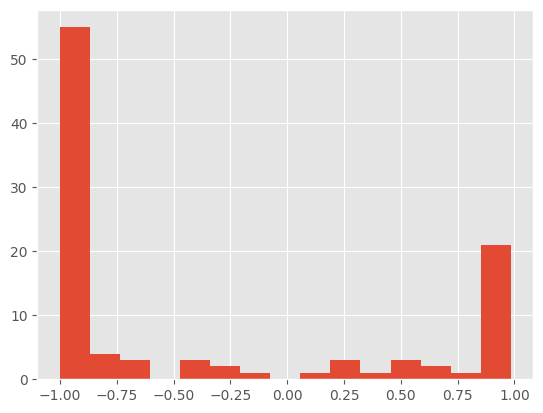

In [3]:
img, label = mnist_dataset[0]
print("Label: ", label)
plt.hist(img[:, 5:15, 5:15].flatten(), bins=15)

In [4]:
# denormalization image from range (-1)-1 to range 0-1 to display it
def denorm(x):
    return ((x-torch.mean(x))/torch.std(x))[0]

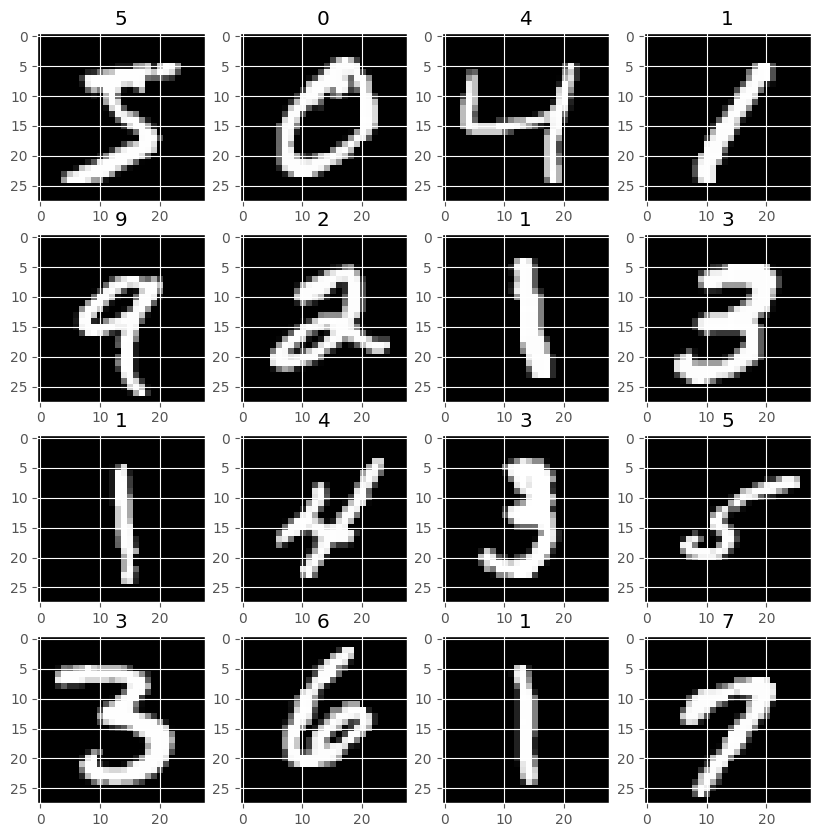

In [5]:
# show image sample with matplotlib
fig = plt.figure(figsize=(10, 10))

for i in range(16):
    fig.add_subplot(4, 4, i+1)
    img, label = mnist_dataset[i]
    plt.title(label)
    plt.imshow(denorm(img), cmap='Greys_r')

In [6]:
# define the dataloader
from torch.utils.data import DataLoader
data_loader = DataLoader(mnist_dataset, batch_size=batch_size)

### GAN implementation

GAN consists of two deep networks, a generator ($G$) and a discriminator ($D$). The generator creates images before learning it. Since the discriminator is a binary classification model, we can use the binary cross-entropy loss function to quantify how well it can distinguish between real and generated images.

In [7]:
class Generator(nn.Module):
    def __init__(self, latent_size, image_size, hidden_size):
        super(Generator, self).__init__()
        ## set a linear layer with input size is latent_size and output size is hidden_size
        self.linear1 = nn.Linear(latent_size, hidden_size)
        # set a linear layer with input size is hidden_size and output size is hidden_size
        self.linear2 = nn.Linear(hidden_size, hidden_size)
        # set a linear layer with input size is hidden_size and output size is image_size
        self.linear3 = nn.Linear(hidden_size, image_size)
        
    def forward(self, x):
        # forward x -> linear1 -> relu -> linear2 -> relu -> linear3 -> tanh
        x = F.relu(self.linear1(x))
        x = F.relu(self.linear2(x))
        return torch.tanh(self.linear3(x))


class Discriminator(nn.Module):
    def __init__(self, image_size, hidden_size):
        super(Discriminator, self).__init__()
        ## set a linear layer with input size is image_size and output size is hidden_size
        self.linear1 = nn.Linear(image_size, hidden_size)
        # set a linear layer with input size is hidden_size and output size is hidden_size
        self.linear2 = nn.Linear(hidden_size, hidden_size)
        # set a linear layer with input size is hidden_size and output size is 1
        self.linear3 = nn.Linear(hidden_size, 1)
    def forward(self, x):
        # forward x -> linear1 -> relu -> linear2 -> relu -> linear3 -> sigmoid
        x = F.relu(self.linear1(x))
        x = F.relu(self.linear2(x))
        return torch.sigmoid(self.linear3(x))

### Create the Generator and Discriminator

In [20]:
# create new Generator model

# G = Generator...
G = Generator(latent_size, image_size, hidden_size).to(device)
# create new Discriminator model

# D = Discriminator...
D = Discriminator(image_size, hidden_size).to(device)

In [21]:
# show the output of model
y = G(torch.randn(2, latent_size).to(device))

In [22]:
y.shape

torch.Size([2, 784])

In [23]:
# define the criterion is nn.BCELoss()
criterion = nn.BCELoss()
## Define the optimizer for generator and discrimator
optim_G = torch.optim.Adam(G.parameters(), lr=LR)
optim_D = torch.optim.Adam(D.parameters(), lr=LR)

Discriminator Training

In [24]:
def reset_grad():
    ## reset gradient for optimizer of generator and discrimator
    optim_D.zero_grad()

def train_discriminator(D_model, G_model, images, device=device, batch_size=batch_size, latent_size=latent_size):

    # Create the labels which are later used as input for the BCE loss
    real_labels = torch.ones(batch_size, 1).to(device)
    fake_labels = torch.zeros(batch_size, 1).to(device)


    outputs = D_model(images)
    # Loss for real images

    real_score = criterion(outputs, real_labels)

    # Loss for fake images
    z = torch.randn(batch_size, latent_size).to(device)
    fake_images = G_model(z)
    outputs = D_model(fake_images)

    fake_score = criterion(outputs, fake_labels)

    # Sum losses
    d_loss = real_score + fake_score
    # Reset gradients
    reset_grad()
    # Compute gradients
    fake_score.backward()
    real_score.backward()
    # Adjust the parameters using backprop
    optim_D.step()
    return d_loss, real_score, fake_score

Generator Training

In [25]:
def train_generator(G_model, device=device, batch_size=batch_size, latent_size=latent_size):
    # Generate fake images and calculate loss
    # z = torch.randn(batch_size, latent_size).to(device)
    z = torch.Tensor(np.random.normal(0, 1, (batch_size, latent_size))).to(device)
    fake_images = G_model(z)
    labels = torch.ones(batch_size, 1).to(device)
    outputs = D(fake_images)
    # calculate the generator loss
    g_loss = criterion(outputs, labels)
    # Reset gradients
    optim_G.zero_grad()
    # Backprop and optimize
    g_loss.backward()
    optim_G.step()
    
    return g_loss, fake_images

### Start the training proccess

In [26]:
# function to save the sample output of generator
def save_fake_images_mnist(G_model, index):
    # sample_vectors = torch.randn(batch_size, latent_size).to(device)
    sample_vectors = torch.Tensor(np.random.normal(0, 1, (batch_size, latent_size))).to(
        device
    )
    fake_images = G_model(sample_vectors)
    fake_images = fake_images.reshape(fake_images.size(0), 1, 28, 28)
    fake_fname = "fake_images-{0:0=4d}.png".format(index)
    print("Saving", fake_fname)
    save_image(denorm(fake_images), os.path.join(sample_dir, fake_fname), nrow=10)

In [27]:
%%time
total_step = len(data_loader)
d_losses, g_losses, real_scores, fake_scores = [], [], [], []
G.to(device)
D.to(device)
for epoch in range(num_epochs):
    for i, (images, _) in enumerate(data_loader):
        # Load a batch & transform to vectors
        images = images.reshape(batch_size, -1).to(device)

        # Train the discriminator
        d_loss, real_score, fake_score = train_discriminator(D, G, images)
        # Train the generator
        g_loss, fake_images = train_generator(G)
        # Inspect the losses
        if (i + 1) % 200 == 0:
            d_losses.append(d_loss.item())
            g_losses.append(g_loss.item())
            real_scores.append(real_score.mean().item())
            fake_scores.append(fake_score.mean().item())
            print(
                "Epoch [{}/{}], Step [{}/{}], d_loss: {:.4f}, g_loss: {:.4f}, D(x): {:.2f}, D(G(z)): {:.2f}".format(
                    epoch,
                    num_epochs,
                    i + 1,
                    total_step,
                    d_loss.item(),
                    g_loss.item(),
                    real_score.mean().item(),
                    fake_score.mean().item(),
                )
            )
    # Sample and save images
    save_fake_images_mnist(G, epoch + 1)

Epoch [0/300], Step [200/600], d_loss: 0.2410, g_loss: 2.3037, D(x): 0.06, D(G(z)): 0.18
Epoch [0/300], Step [400/600], d_loss: 0.4091, g_loss: 2.9181, D(x): 0.13, D(G(z)): 0.28
Epoch [0/300], Step [600/600], d_loss: 0.1206, g_loss: 3.9660, D(x): 0.07, D(G(z)): 0.05
Saving fake_images-0001.png
Epoch [1/300], Step [200/600], d_loss: 0.0965, g_loss: 3.8734, D(x): 0.05, D(G(z)): 0.04
Epoch [1/300], Step [400/600], d_loss: 0.9010, g_loss: 2.2511, D(x): 0.39, D(G(z)): 0.51
Epoch [1/300], Step [600/600], d_loss: 0.3152, g_loss: 2.8321, D(x): 0.14, D(G(z)): 0.17
Saving fake_images-0002.png
Epoch [2/300], Step [200/600], d_loss: 0.8955, g_loss: 1.3600, D(x): 0.62, D(G(z)): 0.27
Epoch [2/300], Step [400/600], d_loss: 2.2317, g_loss: 2.1379, D(x): 1.37, D(G(z)): 0.86
Epoch [2/300], Step [600/600], d_loss: 0.3355, g_loss: 1.7756, D(x): 0.20, D(G(z)): 0.14
Saving fake_images-0003.png
Epoch [3/300], Step [200/600], d_loss: 0.1885, g_loss: 3.1209, D(x): 0.11, D(G(z)): 0.08
Epoch [3/300], Step [400/6

Epoch [27/300], Step [600/600], d_loss: 0.5137, g_loss: 2.5278, D(x): 0.24, D(G(z)): 0.28
Saving fake_images-0028.png
Epoch [28/300], Step [200/600], d_loss: 0.5194, g_loss: 3.1377, D(x): 0.30, D(G(z)): 0.22
Epoch [28/300], Step [400/600], d_loss: 0.5588, g_loss: 2.6767, D(x): 0.31, D(G(z)): 0.25
Epoch [28/300], Step [600/600], d_loss: 0.3220, g_loss: 3.1575, D(x): 0.18, D(G(z)): 0.14
Saving fake_images-0029.png
Epoch [29/300], Step [200/600], d_loss: 0.5205, g_loss: 2.5015, D(x): 0.25, D(G(z)): 0.27
Epoch [29/300], Step [400/600], d_loss: 0.8244, g_loss: 2.1247, D(x): 0.58, D(G(z)): 0.24
Epoch [29/300], Step [600/600], d_loss: 0.3626, g_loss: 2.9999, D(x): 0.11, D(G(z)): 0.25
Saving fake_images-0030.png
Epoch [30/300], Step [200/600], d_loss: 0.3472, g_loss: 2.6542, D(x): 0.24, D(G(z)): 0.11
Epoch [30/300], Step [400/600], d_loss: 0.5752, g_loss: 2.3702, D(x): 0.17, D(G(z)): 0.41
Epoch [30/300], Step [600/600], d_loss: 0.5074, g_loss: 3.2361, D(x): 0.22, D(G(z)): 0.29
Saving fake_imag

Epoch [55/300], Step [400/600], d_loss: 1.0015, g_loss: 1.4234, D(x): 0.21, D(G(z)): 0.79
Epoch [55/300], Step [600/600], d_loss: 0.7777, g_loss: 1.8781, D(x): 0.37, D(G(z)): 0.41
Saving fake_images-0056.png
Epoch [56/300], Step [200/600], d_loss: 0.5080, g_loss: 2.1884, D(x): 0.18, D(G(z)): 0.32
Epoch [56/300], Step [400/600], d_loss: 0.7092, g_loss: 1.8185, D(x): 0.34, D(G(z)): 0.36
Epoch [56/300], Step [600/600], d_loss: 0.6608, g_loss: 1.6224, D(x): 0.20, D(G(z)): 0.46
Saving fake_images-0057.png
Epoch [57/300], Step [200/600], d_loss: 0.6389, g_loss: 1.8513, D(x): 0.25, D(G(z)): 0.39
Epoch [57/300], Step [400/600], d_loss: 0.8989, g_loss: 1.4276, D(x): 0.29, D(G(z)): 0.61
Epoch [57/300], Step [600/600], d_loss: 0.7196, g_loss: 1.5603, D(x): 0.13, D(G(z)): 0.59
Saving fake_images-0058.png
Epoch [58/300], Step [200/600], d_loss: 0.6282, g_loss: 1.7456, D(x): 0.36, D(G(z)): 0.27
Epoch [58/300], Step [400/600], d_loss: 0.5414, g_loss: 2.1057, D(x): 0.18, D(G(z)): 0.36
Epoch [58/300], 

Epoch [83/300], Step [200/600], d_loss: 1.0128, g_loss: 1.3632, D(x): 0.44, D(G(z)): 0.58
Epoch [83/300], Step [400/600], d_loss: 0.9030, g_loss: 1.8419, D(x): 0.47, D(G(z)): 0.44
Epoch [83/300], Step [600/600], d_loss: 0.8946, g_loss: 1.6056, D(x): 0.42, D(G(z)): 0.47
Saving fake_images-0084.png
Epoch [84/300], Step [200/600], d_loss: 0.7527, g_loss: 1.5362, D(x): 0.34, D(G(z)): 0.41
Epoch [84/300], Step [400/600], d_loss: 0.8451, g_loss: 1.7172, D(x): 0.52, D(G(z)): 0.32
Epoch [84/300], Step [600/600], d_loss: 0.8656, g_loss: 1.9685, D(x): 0.30, D(G(z)): 0.57
Saving fake_images-0085.png
Epoch [85/300], Step [200/600], d_loss: 0.9092, g_loss: 1.6251, D(x): 0.37, D(G(z)): 0.54
Epoch [85/300], Step [400/600], d_loss: 1.0800, g_loss: 1.3274, D(x): 0.50, D(G(z)): 0.58
Epoch [85/300], Step [600/600], d_loss: 0.8496, g_loss: 1.3754, D(x): 0.35, D(G(z)): 0.49
Saving fake_images-0086.png
Epoch [86/300], Step [200/600], d_loss: 0.6159, g_loss: 1.9354, D(x): 0.28, D(G(z)): 0.34
Epoch [86/300], 

Epoch [110/300], Step [600/600], d_loss: 0.6263, g_loss: 1.4928, D(x): 0.25, D(G(z)): 0.38
Saving fake_images-0111.png
Epoch [111/300], Step [200/600], d_loss: 0.9680, g_loss: 1.5921, D(x): 0.49, D(G(z)): 0.48
Epoch [111/300], Step [400/600], d_loss: 0.8549, g_loss: 1.5065, D(x): 0.52, D(G(z)): 0.33
Epoch [111/300], Step [600/600], d_loss: 0.9090, g_loss: 1.4487, D(x): 0.36, D(G(z)): 0.55
Saving fake_images-0112.png
Epoch [112/300], Step [200/600], d_loss: 0.9612, g_loss: 1.2759, D(x): 0.41, D(G(z)): 0.55
Epoch [112/300], Step [400/600], d_loss: 0.8048, g_loss: 1.5783, D(x): 0.42, D(G(z)): 0.38
Epoch [112/300], Step [600/600], d_loss: 0.7132, g_loss: 1.6077, D(x): 0.17, D(G(z)): 0.54
Saving fake_images-0113.png
Epoch [113/300], Step [200/600], d_loss: 0.9460, g_loss: 1.4929, D(x): 0.47, D(G(z)): 0.48
Epoch [113/300], Step [400/600], d_loss: 0.9739, g_loss: 1.4830, D(x): 0.48, D(G(z)): 0.49
Epoch [113/300], Step [600/600], d_loss: 0.7160, g_loss: 1.5956, D(x): 0.23, D(G(z)): 0.48
Saving

Epoch [138/300], Step [200/600], d_loss: 0.9460, g_loss: 1.4483, D(x): 0.45, D(G(z)): 0.50
Epoch [138/300], Step [400/600], d_loss: 0.8929, g_loss: 1.4811, D(x): 0.46, D(G(z)): 0.43
Epoch [138/300], Step [600/600], d_loss: 0.7573, g_loss: 1.3613, D(x): 0.28, D(G(z)): 0.48
Saving fake_images-0139.png
Epoch [139/300], Step [200/600], d_loss: 0.8845, g_loss: 1.4860, D(x): 0.44, D(G(z)): 0.44
Epoch [139/300], Step [400/600], d_loss: 0.9411, g_loss: 1.3492, D(x): 0.43, D(G(z)): 0.51
Epoch [139/300], Step [600/600], d_loss: 0.7505, g_loss: 1.3786, D(x): 0.28, D(G(z)): 0.47
Saving fake_images-0140.png
Epoch [140/300], Step [200/600], d_loss: 0.8936, g_loss: 1.4432, D(x): 0.43, D(G(z)): 0.46
Epoch [140/300], Step [400/600], d_loss: 1.1625, g_loss: 1.4579, D(x): 0.66, D(G(z)): 0.50
Epoch [140/300], Step [600/600], d_loss: 0.8463, g_loss: 1.2622, D(x): 0.24, D(G(z)): 0.60
Saving fake_images-0141.png
Epoch [141/300], Step [200/600], d_loss: 1.0190, g_loss: 1.4170, D(x): 0.59, D(G(z)): 0.43
Epoch 

Epoch [165/300], Step [400/600], d_loss: 0.9144, g_loss: 1.6129, D(x): 0.39, D(G(z)): 0.52
Epoch [165/300], Step [600/600], d_loss: 0.9093, g_loss: 1.1895, D(x): 0.28, D(G(z)): 0.63
Saving fake_images-0166.png
Epoch [166/300], Step [200/600], d_loss: 0.9144, g_loss: 1.3254, D(x): 0.30, D(G(z)): 0.61
Epoch [166/300], Step [400/600], d_loss: 0.9881, g_loss: 1.3758, D(x): 0.51, D(G(z)): 0.48
Epoch [166/300], Step [600/600], d_loss: 0.8442, g_loss: 1.3174, D(x): 0.19, D(G(z)): 0.65
Saving fake_images-0167.png
Epoch [167/300], Step [200/600], d_loss: 0.7161, g_loss: 1.4152, D(x): 0.31, D(G(z)): 0.40
Epoch [167/300], Step [400/600], d_loss: 0.9582, g_loss: 1.5565, D(x): 0.56, D(G(z)): 0.40
Epoch [167/300], Step [600/600], d_loss: 0.7864, g_loss: 1.3024, D(x): 0.30, D(G(z)): 0.48
Saving fake_images-0168.png
Epoch [168/300], Step [200/600], d_loss: 0.7529, g_loss: 1.3336, D(x): 0.36, D(G(z)): 0.39
Epoch [168/300], Step [400/600], d_loss: 0.9899, g_loss: 1.4857, D(x): 0.50, D(G(z)): 0.49
Epoch 

Epoch [192/300], Step [600/600], d_loss: 0.8802, g_loss: 1.0974, D(x): 0.27, D(G(z)): 0.61
Saving fake_images-0193.png
Epoch [193/300], Step [200/600], d_loss: 0.8016, g_loss: 1.3966, D(x): 0.40, D(G(z)): 0.40
Epoch [193/300], Step [400/600], d_loss: 0.9741, g_loss: 1.4983, D(x): 0.53, D(G(z)): 0.44
Epoch [193/300], Step [600/600], d_loss: 0.7920, g_loss: 1.2375, D(x): 0.30, D(G(z)): 0.50
Saving fake_images-0194.png
Epoch [194/300], Step [200/600], d_loss: 0.8804, g_loss: 1.5364, D(x): 0.40, D(G(z)): 0.48
Epoch [194/300], Step [400/600], d_loss: 0.8975, g_loss: 1.5035, D(x): 0.43, D(G(z)): 0.47
Epoch [194/300], Step [600/600], d_loss: 0.9171, g_loss: 1.5241, D(x): 0.32, D(G(z)): 0.60
Saving fake_images-0195.png
Epoch [195/300], Step [200/600], d_loss: 0.8462, g_loss: 1.4431, D(x): 0.47, D(G(z)): 0.37
Epoch [195/300], Step [400/600], d_loss: 0.9632, g_loss: 1.2720, D(x): 0.40, D(G(z)): 0.56
Epoch [195/300], Step [600/600], d_loss: 0.7330, g_loss: 1.5821, D(x): 0.34, D(G(z)): 0.39
Saving

Epoch [220/300], Step [200/600], d_loss: 0.8815, g_loss: 1.6840, D(x): 0.45, D(G(z)): 0.43
Epoch [220/300], Step [400/600], d_loss: 0.9633, g_loss: 1.8074, D(x): 0.63, D(G(z)): 0.33
Epoch [220/300], Step [600/600], d_loss: 0.8013, g_loss: 1.6550, D(x): 0.28, D(G(z)): 0.52
Saving fake_images-0221.png
Epoch [221/300], Step [200/600], d_loss: 0.8274, g_loss: 1.4893, D(x): 0.40, D(G(z)): 0.43
Epoch [221/300], Step [400/600], d_loss: 0.9500, g_loss: 1.3613, D(x): 0.51, D(G(z)): 0.44
Epoch [221/300], Step [600/600], d_loss: 0.7471, g_loss: 1.4296, D(x): 0.26, D(G(z)): 0.48
Saving fake_images-0222.png
Epoch [222/300], Step [200/600], d_loss: 0.8821, g_loss: 1.3285, D(x): 0.44, D(G(z)): 0.44
Epoch [222/300], Step [400/600], d_loss: 0.9935, g_loss: 1.7595, D(x): 0.61, D(G(z)): 0.39
Epoch [222/300], Step [600/600], d_loss: 0.7378, g_loss: 1.4443, D(x): 0.27, D(G(z)): 0.46
Saving fake_images-0223.png
Epoch [223/300], Step [200/600], d_loss: 0.9567, g_loss: 1.4334, D(x): 0.46, D(G(z)): 0.50
Epoch 

Epoch [247/300], Step [400/600], d_loss: 0.8931, g_loss: 1.5288, D(x): 0.54, D(G(z)): 0.36
Epoch [247/300], Step [600/600], d_loss: 0.7911, g_loss: 1.6209, D(x): 0.32, D(G(z)): 0.47
Saving fake_images-0248.png
Epoch [248/300], Step [200/600], d_loss: 0.9257, g_loss: 1.5104, D(x): 0.48, D(G(z)): 0.44
Epoch [248/300], Step [400/600], d_loss: 0.9655, g_loss: 1.5664, D(x): 0.53, D(G(z)): 0.43
Epoch [248/300], Step [600/600], d_loss: 0.7232, g_loss: 1.3948, D(x): 0.27, D(G(z)): 0.46
Saving fake_images-0249.png
Epoch [249/300], Step [200/600], d_loss: 1.0399, g_loss: 1.5198, D(x): 0.40, D(G(z)): 0.64
Epoch [249/300], Step [400/600], d_loss: 1.0414, g_loss: 1.6468, D(x): 0.49, D(G(z)): 0.55
Epoch [249/300], Step [600/600], d_loss: 0.7315, g_loss: 1.5802, D(x): 0.29, D(G(z)): 0.44
Saving fake_images-0250.png
Epoch [250/300], Step [200/600], d_loss: 0.8532, g_loss: 1.5630, D(x): 0.43, D(G(z)): 0.43
Epoch [250/300], Step [400/600], d_loss: 0.9598, g_loss: 1.6138, D(x): 0.55, D(G(z)): 0.41
Epoch 

Epoch [274/300], Step [600/600], d_loss: 0.7749, g_loss: 1.5816, D(x): 0.33, D(G(z)): 0.45
Saving fake_images-0275.png
Epoch [275/300], Step [200/600], d_loss: 0.8941, g_loss: 1.2358, D(x): 0.41, D(G(z)): 0.48
Epoch [275/300], Step [400/600], d_loss: 0.9198, g_loss: 1.6548, D(x): 0.48, D(G(z)): 0.44
Epoch [275/300], Step [600/600], d_loss: 0.7338, g_loss: 1.5491, D(x): 0.29, D(G(z)): 0.45
Saving fake_images-0276.png
Epoch [276/300], Step [200/600], d_loss: 0.9312, g_loss: 1.4848, D(x): 0.42, D(G(z)): 0.51
Epoch [276/300], Step [400/600], d_loss: 0.8330, g_loss: 1.4844, D(x): 0.48, D(G(z)): 0.35
Epoch [276/300], Step [600/600], d_loss: 0.8293, g_loss: 1.4420, D(x): 0.36, D(G(z)): 0.47
Saving fake_images-0277.png
Epoch [277/300], Step [200/600], d_loss: 0.8346, g_loss: 1.4206, D(x): 0.36, D(G(z)): 0.48
Epoch [277/300], Step [400/600], d_loss: 1.0160, g_loss: 1.6837, D(x): 0.47, D(G(z)): 0.54
Epoch [277/300], Step [600/600], d_loss: 0.9100, g_loss: 1.4505, D(x): 0.44, D(G(z)): 0.47
Saving

In [10]:
# show output after epochs training
Image.open(os.path.join(sample_dir, "fake_images-0295.png"))

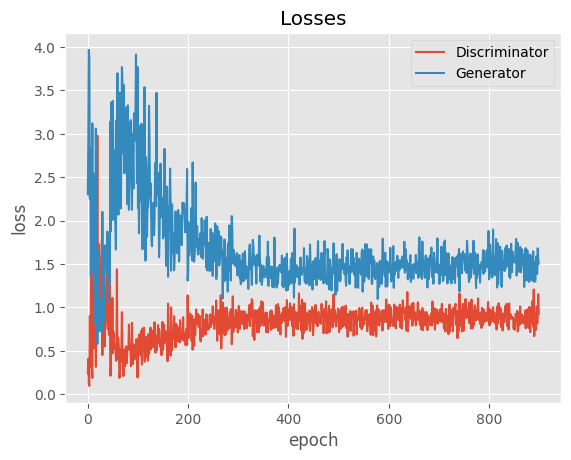

In [29]:
# show the discrimator loss and generator loss
plt.plot(d_losses, "-")
plt.plot(g_losses, "-")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.legend(["Discriminator", "Generator"])
plt.title("Losses");

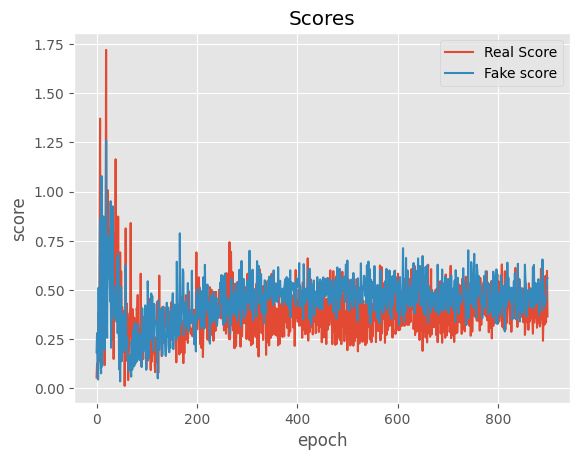

In [30]:
# plot the accuracy of discrimator
plt.plot(real_scores, "-")
plt.plot(fake_scores, "-")
plt.xlabel("epoch")
plt.ylabel("score")
plt.legend(["Real Score", "Fake score"])
plt.title("Scores");

## 2. DCGAN

*Source: <a href="https://arxiv.org/pdf/1511.06434v2.pdf" target="_blank">Radford, Alec, Luke Metz, and Soumith Chintala. "Unsupervised representation learning with deep convolutional generative adversarial networks." arXiv preprint arXiv:1511.06434 (2015)</a>.*

The goal of this part is to enhance your results achieved in the part one with DCGAN. Feel free to reuse your code, improve architecture or training scheme, etc.

In [101]:
class CFG:
    batch_size = 128
    num_epochs = 300
    workers = 4
    seed = 2021
    image_size = 64
    download = True
    dataroot = "data"
    nc = 3  ## number of chanels
    ngf = 64  # Size of feature maps in generator
    nz = 100  # latent random input vector
    ndf = 64  # Size of feature maps in discriminator
    lr = 0.0002
    device = "cuda" if torch.cuda.is_available() else "cpu"
    sample_dir = "./images2"


if not os.path.exists(CFG.sample_dir):
    os.makedirs(CFG.sample_dir)

cifar_dataset = CIFAR10(
    root=CFG.dataroot,
    download=CFG.download,
    transform=transforms.Compose(
        [
            transforms.Resize([CFG.image_size, CFG.image_size]),
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
        ]
    ),
)

Files already downloaded and verified


Label:  6


(array([ 3.,  6., 52., 36.,  6.,  4., 12., 40., 40.,  7.,  2.,  6., 22.,
        32., 32.]),
 array([-0.87450981, -0.81124181, -0.74797386, -0.68470585, -0.62143791,
        -0.5581699 , -0.49490196, -0.43163398, -0.36836597, -0.305098  ,
        -0.24183004, -0.17856206, -0.11529408, -0.0520261 ,  0.01124188,
         0.07450986]),
 <BarContainer object of 15 artists>)

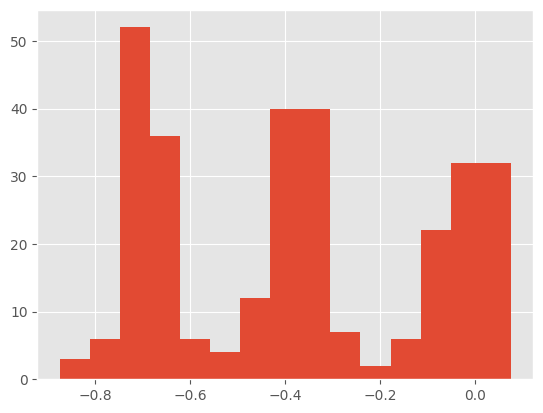

In [102]:
img, label = cifar_dataset[0]
print("Label: ", label)
plt.hist(img[:, 5:15, 5:15].flatten(), bins=15)

In [197]:
def denorm1(img):
    AA = img.clone()
    AA = AA.view(AA.size(0), -1)
    AA -= AA.min(1, keepdim=True)[0]
    AA /= AA.max(1, keepdim=True)[0]
    AA = AA.view(3, 64, 64)
    return AA

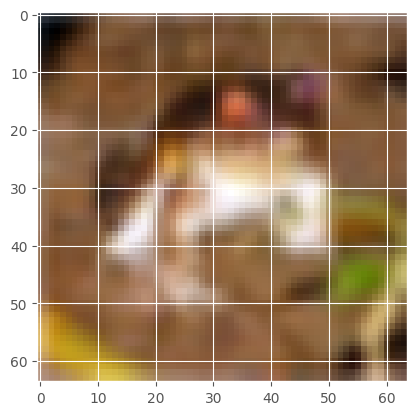

In [198]:
plt.imshow(np.transpose(denorm1(img).detach().cpu(),(1,2,0)))

In [105]:
# create the dataloader
from torch.utils.data import DataLoader
data_loader = DataLoader(cifar_dataset, 
                         batch_size=CFG.batch_size,
                        shuffle=True,
                        num_workers=CFG.workers)

### DCGAN implementation

In [187]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [188]:
class DCGenerator(nn.Module):
    def __init__(self, nc, nz, ngf):
        # ConvTranspose2d - BatchNorm - Relu -ConvTranspose2d - BatchNorm - Relu -ConvTranspose2d - BatchNorm - Relu
        # ConvTranspose2d - BatchNorm - Relu - ConvTranspose2d - Tanh
        super(DCGenerator, self).__init__()
        self.main = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d( nz, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            # state size. (ngf*8) x 4 x 4
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # state size. (ngf*4) x 8 x 8
            nn.ConvTranspose2d( ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # state size. (ngf*2) x 16 x 16
            nn.ConvTranspose2d( ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # state size. (ngf) x 32 x 32
            nn.ConvTranspose2d( ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()
            # state size. (nc) x 64 x 64
        )

    def forward(self, x):
        return self.main(x)


class DCDiscriminator(nn.Module):
    def __init__(self, nc, ndf):
        # conv2d - leaky - conv2d - batchnorm - leaky - conv2d - batchnorm - leaky - conv - batchnorm - leaky - conv2d
        super(DCDiscriminator, self).__init__()
        self.main = nn.Sequential(
            # input is (nc) x 64 x 64
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf) x 32 x 32
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*2) x 16 x 16
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*4) x 8 x 8
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.main(x)

In [189]:
# create new Generator model
DCG = DCGenerator(CFG.nc, CFG.nz, CFG.ngf).to(CFG.device)
# DCG.apply(weights_init)
# create new Discriminator model
DCD = DCDiscriminator(CFG.nc, CFG.ndf).to(CFG.device)
# DCD.apply(weights_init)

In [190]:
# show the output of model
y = DCG(torch.randn(64, CFG.nz, 1, 1, device=device))
y.shape

torch.Size([64, 3, 64, 64])

In [191]:
# define the criterion is nn.BCELoss()
criterion = nn.BCELoss()
## Define the optimizer for generator and discrimator
optimizerD = torch.optim.Adam(DCD.parameters(), lr=CFG.lr)
optimizerG = torch.optim.Adam(DCG.parameters(), lr=CFG.lr)

In [192]:
def reset_grad():
    ## reset gradient for optimizer of generator and discrimator
    optimizerG.zero_grad()
    optimizerD.zero_grad()

def train_dcdiscriminator(D_model, G_model, images, device=CFG.device, batch_size=CFG.batch_size, latent_size=CFG.nz):
  
    # Create the labels which are later used as input for the BCE loss
    real_labels = torch.ones(batch_size).to(device)
    fake_labels = torch.zeros(batch_size).to(device)
        
    # Loss for real image
    outputs = D_model(images).view(-1)
    real_score = criterion(outputs, real_labels)
    


    # Loss for fake images
    z = torch.randn(batch_size, latent_size, 1, 1).to(device)
    fake_images = G_model(z)
    outputs = D_model(fake_images).view(-1)
    fake_score = criterion(outputs, fake_labels)


    # Sum losses
    d_loss = real_score + fake_score
    # Reset gradients
    reset_grad()
    # Compute gradients
    fake_score.backward()
    real_score.backward()
    # Adjust the parameters using backprop
    optimizerD.step()

    return d_loss, real_score, fake_score

In [193]:
def train_dcgenerator(G_model, device=CFG.device, batch_size=CFG.batch_size, latent_size=CFG.nz):
    # Generate fake images and calculate loss
    z = torch.randn(batch_size, latent_size, 1, 1).to(device)
    fake_images = G_model(z)
    labels = torch.ones(batch_size).to(device)
    outputs = DCD(fake_images).view(-1)
    # calculate the generator loss
    g_loss = criterion(outputs, labels)
    # Reset gradients
    optimizerG.zero_grad()
    # Backprop and optimize
    g_loss.backward()
    optimizerG.step()

    return g_loss, fake_images

### Start the training proccess

In [194]:
def denorm(img):
    AA = img.clone()
    AA = AA.view(AA.size(0),AA.size(1), -1)
    AA -= AA.min(2, keepdim=True)[0]
    AA /= AA.max(2, keepdim=True)[0]
    AA = AA.view(AA.size(0), 3, 64, 64)
    return AA

In [195]:
def save_fake_images_cifar(DCG_model, index):
    sample_vectors = torch.randn(CFG.batch_size, CFG.nz, 1, 1).to(CFG.device)
    fake_images = DCG_model(sample_vectors)
    fake_images = fake_images.reshape(fake_images.size(0), 3, 64, 64)
    fake_fname = "fake_images-{0:0=4d}.png".format(index)
    print("Saving", fake_fname)
    save_image(
        denorm(fake_images), os.path.join(CFG.sample_dir, fake_fname), nrow=10
    )

In [196]:
%%time
total_step = len(data_loader)
d_losses, g_losses, real_scores, fake_scores = [], [], [], []
DCG.to(CFG.device)
DCD.to(CFG.device)
for epoch in range(CFG.num_epochs):
    for i, data in enumerate(data_loader, 0):
        # Load a batch & transform to vectors
        images = data[0].to(CFG.device)
        if(len(images)==CFG.batch_size):
            # Train the discriminator
            d_loss, real_score, fake_score = train_dcdiscriminator(DCD, DCG, images)
            # Train the generator
            g_loss, fake_images = train_dcgenerator(DCG)
            # Inspect the losses
        if (i + 1) % 125 == 0:
            d_losses.append(d_loss.item())
            g_losses.append(g_loss.item())
            real_scores.append(real_score.mean().item())
            fake_scores.append(fake_score.mean().item())
            print(
                "Epoch [{}/{}], Step [{}/{}], d_loss: {:.4f}, g_loss: {:.4f}, D(x): {:.2f}, D(G(z)): {:.2f}".format(
                    epoch,
                    CFG.num_epochs,
                    i + 1,
                    total_step,
                    d_loss.item(),
                    g_loss.item(),
                    real_score.mean().item(),
                    fake_score.mean().item(),
                )
            )
    # Sample and save images
    save_fake_images_cifar(DCG, epoch + 1)
    if epoch%10==0:
        torch.save(DCG, 'DCG')
        torch.save(DCD, 'DCD')

Epoch [0/300], Step [125/391], d_loss: 0.0088, g_loss: 10.3491, D(x): 0.00, D(G(z)): 0.00
Epoch [0/300], Step [250/391], d_loss: 0.0352, g_loss: 13.5753, D(x): 0.03, D(G(z)): 0.00
Epoch [0/300], Step [375/391], d_loss: 0.0306, g_loss: 8.9821, D(x): 0.03, D(G(z)): 0.00
Saving fake_images-0001.png
Epoch [1/300], Step [125/391], d_loss: 0.0002, g_loss: 15.7059, D(x): 0.00, D(G(z)): 0.00
Epoch [1/300], Step [250/391], d_loss: 0.0133, g_loss: 7.8989, D(x): 0.00, D(G(z)): 0.01
Epoch [1/300], Step [375/391], d_loss: 0.0472, g_loss: 11.2974, D(x): 0.00, D(G(z)): 0.05
Saving fake_images-0002.png
Epoch [2/300], Step [125/391], d_loss: 0.0283, g_loss: 10.1596, D(x): 0.02, D(G(z)): 0.01
Epoch [2/300], Step [250/391], d_loss: 0.0093, g_loss: 14.9015, D(x): 0.01, D(G(z)): 0.00
Epoch [2/300], Step [375/391], d_loss: 0.0039, g_loss: 6.7831, D(x): 0.00, D(G(z)): 0.00
Saving fake_images-0003.png
Epoch [3/300], Step [125/391], d_loss: 0.0382, g_loss: 10.3416, D(x): 0.03, D(G(z)): 0.00
Epoch [3/300], Step

Epoch [27/300], Step [375/391], d_loss: 0.1362, g_loss: 13.0030, D(x): 0.14, D(G(z)): 0.00
Saving fake_images-0028.png
Epoch [28/300], Step [125/391], d_loss: 0.1855, g_loss: 4.2959, D(x): 0.16, D(G(z)): 0.03
Epoch [28/300], Step [250/391], d_loss: 0.0625, g_loss: 5.7122, D(x): 0.00, D(G(z)): 0.06
Epoch [28/300], Step [375/391], d_loss: 0.0094, g_loss: 7.2990, D(x): 0.00, D(G(z)): 0.01
Saving fake_images-0029.png
Epoch [29/300], Step [125/391], d_loss: 0.2244, g_loss: 3.6626, D(x): 0.15, D(G(z)): 0.07
Epoch [29/300], Step [250/391], d_loss: 0.0232, g_loss: 7.8951, D(x): 0.01, D(G(z)): 0.02
Epoch [29/300], Step [375/391], d_loss: 0.0770, g_loss: 16.6057, D(x): 0.07, D(G(z)): 0.00
Saving fake_images-0030.png
Epoch [30/300], Step [125/391], d_loss: 0.1300, g_loss: 3.9254, D(x): 0.00, D(G(z)): 0.13
Epoch [30/300], Step [250/391], d_loss: 0.0124, g_loss: 11.0956, D(x): 0.01, D(G(z)): 0.00
Epoch [30/300], Step [375/391], d_loss: 0.2172, g_loss: 6.9933, D(x): 0.01, D(G(z)): 0.21
Saving fake_i

Epoch [55/300], Step [250/391], d_loss: 0.7827, g_loss: 5.7194, D(x): 0.78, D(G(z)): 0.00
Epoch [55/300], Step [375/391], d_loss: 0.0935, g_loss: 6.2316, D(x): 0.08, D(G(z)): 0.01
Saving fake_images-0056.png
Epoch [56/300], Step [125/391], d_loss: 0.0483, g_loss: 7.3195, D(x): 0.04, D(G(z)): 0.00
Epoch [56/300], Step [250/391], d_loss: 0.1453, g_loss: 4.3250, D(x): 0.03, D(G(z)): 0.12
Epoch [56/300], Step [375/391], d_loss: 0.4634, g_loss: 8.4205, D(x): 0.46, D(G(z)): 0.00
Saving fake_images-0057.png
Epoch [57/300], Step [125/391], d_loss: 0.4847, g_loss: 3.9622, D(x): 0.00, D(G(z)): 0.48
Epoch [57/300], Step [250/391], d_loss: 0.1174, g_loss: 3.4555, D(x): 0.07, D(G(z)): 0.05
Epoch [57/300], Step [375/391], d_loss: 0.7007, g_loss: 2.9227, D(x): 0.33, D(G(z)): 0.38
Saving fake_images-0058.png
Epoch [58/300], Step [125/391], d_loss: 0.1590, g_loss: 7.3088, D(x): 0.10, D(G(z)): 0.06
Epoch [58/300], Step [250/391], d_loss: 0.0347, g_loss: 4.9689, D(x): 0.01, D(G(z)): 0.03
Epoch [58/300], 

Saving fake_images-0083.png
Epoch [83/300], Step [125/391], d_loss: 0.4298, g_loss: 6.2485, D(x): 0.43, D(G(z)): 0.00
Epoch [83/300], Step [250/391], d_loss: 2.1779, g_loss: 6.9312, D(x): 2.18, D(G(z)): 0.00
Epoch [83/300], Step [375/391], d_loss: 0.0716, g_loss: 4.1659, D(x): 0.03, D(G(z)): 0.04
Saving fake_images-0084.png
Epoch [84/300], Step [125/391], d_loss: 0.1244, g_loss: 6.5446, D(x): 0.12, D(G(z)): 0.00
Epoch [84/300], Step [250/391], d_loss: 0.0026, g_loss: 9.4304, D(x): 0.00, D(G(z)): 0.00
Epoch [84/300], Step [375/391], d_loss: 0.0177, g_loss: 7.7819, D(x): 0.00, D(G(z)): 0.02
Saving fake_images-0085.png
Epoch [85/300], Step [125/391], d_loss: 0.1588, g_loss: 5.5507, D(x): 0.05, D(G(z)): 0.11
Epoch [85/300], Step [250/391], d_loss: 0.0904, g_loss: 7.4188, D(x): 0.09, D(G(z)): 0.00
Epoch [85/300], Step [375/391], d_loss: 0.1351, g_loss: 5.9773, D(x): 0.13, D(G(z)): 0.00
Saving fake_images-0086.png
Epoch [86/300], Step [125/391], d_loss: 0.9677, g_loss: 4.6260, D(x): 0.94, D(

Epoch [110/300], Step [250/391], d_loss: 0.0995, g_loss: 5.8567, D(x): 0.02, D(G(z)): 0.08
Epoch [110/300], Step [375/391], d_loss: 0.0855, g_loss: 6.9659, D(x): 0.08, D(G(z)): 0.00
Saving fake_images-0111.png
Epoch [111/300], Step [125/391], d_loss: 0.0746, g_loss: 8.2949, D(x): 0.01, D(G(z)): 0.06
Epoch [111/300], Step [250/391], d_loss: 0.2443, g_loss: 3.3357, D(x): 0.00, D(G(z)): 0.24
Epoch [111/300], Step [375/391], d_loss: 0.1522, g_loss: 2.9902, D(x): 0.01, D(G(z)): 0.15
Saving fake_images-0112.png
Epoch [112/300], Step [125/391], d_loss: 0.1956, g_loss: 2.3931, D(x): 0.02, D(G(z)): 0.18
Epoch [112/300], Step [250/391], d_loss: 0.4418, g_loss: 5.8238, D(x): 0.44, D(G(z)): 0.00
Epoch [112/300], Step [375/391], d_loss: 0.1111, g_loss: 5.7389, D(x): 0.00, D(G(z)): 0.11
Saving fake_images-0113.png
Epoch [113/300], Step [125/391], d_loss: 0.2074, g_loss: 2.1594, D(x): 0.00, D(G(z)): 0.21
Epoch [113/300], Step [250/391], d_loss: 0.0072, g_loss: 11.2013, D(x): 0.00, D(G(z)): 0.01
Epoch

Epoch [137/300], Step [375/391], d_loss: 0.0974, g_loss: 5.1903, D(x): 0.07, D(G(z)): 0.03
Saving fake_images-0138.png
Epoch [138/300], Step [125/391], d_loss: 0.4401, g_loss: 2.2922, D(x): 0.00, D(G(z)): 0.44
Epoch [138/300], Step [250/391], d_loss: 0.0231, g_loss: 6.3406, D(x): 0.02, D(G(z)): 0.01
Epoch [138/300], Step [375/391], d_loss: 0.1177, g_loss: 6.1265, D(x): 0.02, D(G(z)): 0.09
Saving fake_images-0139.png
Epoch [139/300], Step [125/391], d_loss: 0.0270, g_loss: 7.2278, D(x): 0.01, D(G(z)): 0.01
Epoch [139/300], Step [250/391], d_loss: 0.0388, g_loss: 3.2321, D(x): 0.01, D(G(z)): 0.03
Epoch [139/300], Step [375/391], d_loss: 0.0745, g_loss: 9.8267, D(x): 0.07, D(G(z)): 0.00
Saving fake_images-0140.png
Epoch [140/300], Step [125/391], d_loss: 0.1768, g_loss: 3.4714, D(x): 0.01, D(G(z)): 0.17
Epoch [140/300], Step [250/391], d_loss: 0.2216, g_loss: 4.4899, D(x): 0.09, D(G(z)): 0.13
Epoch [140/300], Step [375/391], d_loss: 0.0117, g_loss: 5.4524, D(x): 0.00, D(G(z)): 0.01
Saving

Saving fake_images-0165.png
Epoch [165/300], Step [125/391], d_loss: 0.0592, g_loss: 8.1522, D(x): 0.06, D(G(z)): 0.00
Epoch [165/300], Step [250/391], d_loss: 0.1825, g_loss: 5.3639, D(x): 0.18, D(G(z)): 0.01
Epoch [165/300], Step [375/391], d_loss: 0.0757, g_loss: 6.6498, D(x): 0.07, D(G(z)): 0.00
Saving fake_images-0166.png
Epoch [166/300], Step [125/391], d_loss: 0.0080, g_loss: 10.9088, D(x): 0.01, D(G(z)): 0.00
Epoch [166/300], Step [250/391], d_loss: 0.1006, g_loss: 5.5964, D(x): 0.01, D(G(z)): 0.09
Epoch [166/300], Step [375/391], d_loss: 0.2565, g_loss: 4.5384, D(x): 0.01, D(G(z)): 0.25
Saving fake_images-0167.png
Epoch [167/300], Step [125/391], d_loss: 0.0895, g_loss: 8.5164, D(x): 0.09, D(G(z)): 0.00
Epoch [167/300], Step [250/391], d_loss: 0.1402, g_loss: 6.9914, D(x): 0.14, D(G(z)): 0.00
Epoch [167/300], Step [375/391], d_loss: 0.2631, g_loss: 8.4669, D(x): 0.26, D(G(z)): 0.00
Saving fake_images-0168.png
Epoch [168/300], Step [125/391], d_loss: 0.0745, g_loss: 5.5262, D(x

Epoch [192/300], Step [250/391], d_loss: 0.0323, g_loss: 9.1902, D(x): 0.02, D(G(z)): 0.01
Epoch [192/300], Step [375/391], d_loss: 0.0312, g_loss: 4.6267, D(x): 0.01, D(G(z)): 0.03
Saving fake_images-0193.png
Epoch [193/300], Step [125/391], d_loss: 0.0538, g_loss: 4.3832, D(x): 0.00, D(G(z)): 0.05
Epoch [193/300], Step [250/391], d_loss: 0.0627, g_loss: 6.5763, D(x): 0.06, D(G(z)): 0.00
Epoch [193/300], Step [375/391], d_loss: 0.0091, g_loss: 7.2253, D(x): 0.01, D(G(z)): 0.00
Saving fake_images-0194.png
Epoch [194/300], Step [125/391], d_loss: 0.0238, g_loss: 4.9813, D(x): 0.02, D(G(z)): 0.00
Epoch [194/300], Step [250/391], d_loss: 0.0551, g_loss: 7.7091, D(x): 0.05, D(G(z)): 0.00
Epoch [194/300], Step [375/391], d_loss: 0.1983, g_loss: 6.2929, D(x): 0.20, D(G(z)): 0.00
Saving fake_images-0195.png
Epoch [195/300], Step [125/391], d_loss: 0.0069, g_loss: 6.5496, D(x): 0.00, D(G(z)): 0.00
Epoch [195/300], Step [250/391], d_loss: 0.3821, g_loss: 4.4848, D(x): 0.38, D(G(z)): 0.00
Epoch 

Epoch [219/300], Step [375/391], d_loss: 0.0784, g_loss: 6.1219, D(x): 0.07, D(G(z)): 0.01
Saving fake_images-0220.png
Epoch [220/300], Step [125/391], d_loss: 0.0659, g_loss: 4.2046, D(x): 0.00, D(G(z)): 0.06
Epoch [220/300], Step [250/391], d_loss: 0.1119, g_loss: 5.1551, D(x): 0.01, D(G(z)): 0.10
Epoch [220/300], Step [375/391], d_loss: 0.1916, g_loss: 6.7804, D(x): 0.00, D(G(z)): 0.19
Saving fake_images-0221.png
Epoch [221/300], Step [125/391], d_loss: 0.0303, g_loss: 5.5950, D(x): 0.00, D(G(z)): 0.03
Epoch [221/300], Step [250/391], d_loss: 0.0524, g_loss: 4.6938, D(x): 0.01, D(G(z)): 0.04
Epoch [221/300], Step [375/391], d_loss: 0.0190, g_loss: 4.5213, D(x): 0.01, D(G(z)): 0.01
Saving fake_images-0222.png
Epoch [222/300], Step [125/391], d_loss: 0.0256, g_loss: 4.4488, D(x): 0.00, D(G(z)): 0.02
Epoch [222/300], Step [250/391], d_loss: 0.0247, g_loss: 5.6935, D(x): 0.02, D(G(z)): 0.01
Epoch [222/300], Step [375/391], d_loss: 0.0157, g_loss: 5.4029, D(x): 0.01, D(G(z)): 0.00
Saving

Saving fake_images-0247.png
Epoch [247/300], Step [125/391], d_loss: 0.0623, g_loss: 5.7623, D(x): 0.05, D(G(z)): 0.02
Epoch [247/300], Step [250/391], d_loss: 0.0059, g_loss: 7.3704, D(x): 0.00, D(G(z)): 0.00
Epoch [247/300], Step [375/391], d_loss: 0.0287, g_loss: 6.5002, D(x): 0.02, D(G(z)): 0.00
Saving fake_images-0248.png
Epoch [248/300], Step [125/391], d_loss: 0.0074, g_loss: 6.4343, D(x): 0.00, D(G(z)): 0.00
Epoch [248/300], Step [250/391], d_loss: 0.1934, g_loss: 7.0964, D(x): 0.00, D(G(z)): 0.19
Epoch [248/300], Step [375/391], d_loss: 0.0947, g_loss: 3.4798, D(x): 0.00, D(G(z)): 0.09
Saving fake_images-0249.png
Epoch [249/300], Step [125/391], d_loss: 0.0303, g_loss: 5.0245, D(x): 0.01, D(G(z)): 0.02
Epoch [249/300], Step [250/391], d_loss: 0.0274, g_loss: 5.0702, D(x): 0.02, D(G(z)): 0.01
Epoch [249/300], Step [375/391], d_loss: 0.0226, g_loss: 5.3429, D(x): 0.00, D(G(z)): 0.02
Saving fake_images-0250.png
Epoch [250/300], Step [125/391], d_loss: 0.0100, g_loss: 7.1281, D(x)

Epoch [274/300], Step [250/391], d_loss: 0.1679, g_loss: 7.3031, D(x): 0.17, D(G(z)): 0.00
Epoch [274/300], Step [375/391], d_loss: 0.0891, g_loss: 6.5243, D(x): 0.03, D(G(z)): 0.06
Saving fake_images-0275.png
Epoch [275/300], Step [125/391], d_loss: 0.1162, g_loss: 3.8372, D(x): 0.00, D(G(z)): 0.11
Epoch [275/300], Step [250/391], d_loss: 0.0285, g_loss: 6.5136, D(x): 0.01, D(G(z)): 0.02
Epoch [275/300], Step [375/391], d_loss: 0.0116, g_loss: 5.8613, D(x): 0.00, D(G(z)): 0.01
Saving fake_images-0276.png
Epoch [276/300], Step [125/391], d_loss: 0.0190, g_loss: 5.6060, D(x): 0.02, D(G(z)): 0.00
Epoch [276/300], Step [250/391], d_loss: 0.0138, g_loss: 5.4387, D(x): 0.00, D(G(z)): 0.01
Epoch [276/300], Step [375/391], d_loss: 0.0262, g_loss: 7.2854, D(x): 0.02, D(G(z)): 0.01
Saving fake_images-0277.png
Epoch [277/300], Step [125/391], d_loss: 0.0423, g_loss: 7.3284, D(x): 0.04, D(G(z)): 0.00
Epoch [277/300], Step [250/391], d_loss: 0.0148, g_loss: 5.7519, D(x): 0.00, D(G(z)): 0.01
Epoch 

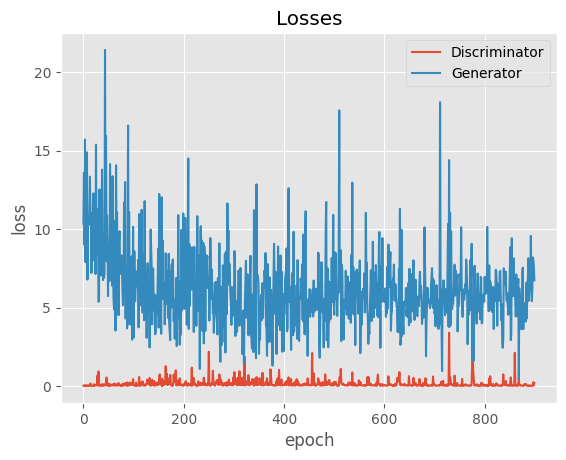

In [199]:
# show the discrimator loss and generator loss
plt.plot(d_losses, "-")
plt.plot(g_losses, "-")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.legend(["Discriminator", "Generator"])
plt.title("Losses");

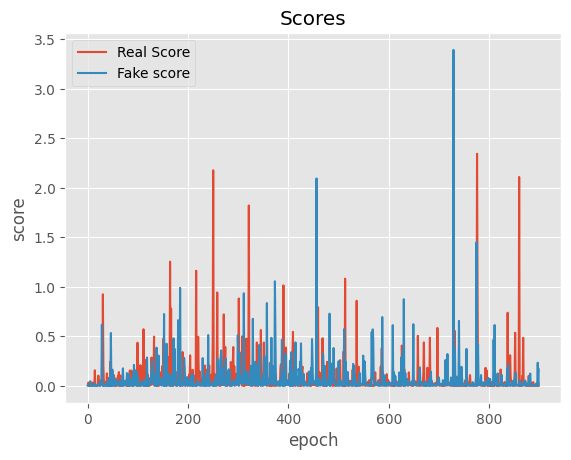

In [200]:
# plot the accuracy of discrimator
plt.plot(real_scores, "-")
plt.plot(fake_scores, "-")
plt.xlabel("epoch")
plt.ylabel("score")
plt.legend(["Real Score", "Fake score"])
plt.title("Scores");

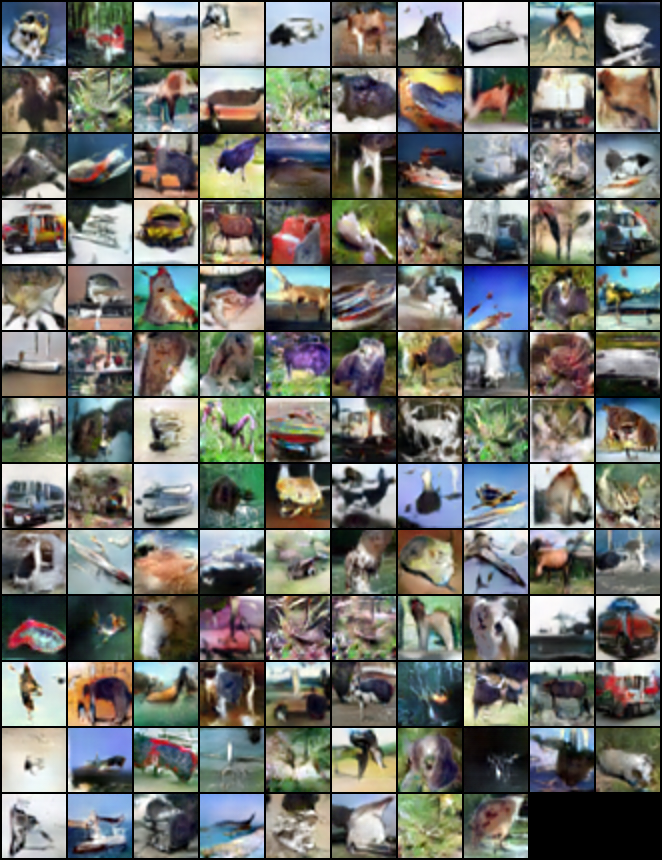

In [202]:
Image.open(os.path.join(CFG.sample_dir, "fake_images-0298.png"))